# About  the data
PJM Interconnection LLC (PJM) is a regional transmission organization (RTO) in the United States. It is part of the Eastern Interconnection grid operating an electric transmission system serving all or parts of Delaware, Illinois, Indiana, Kentucky, Maryland, Michigan, New Jersey, North Carolina, Ohio, Pennsylvania, Tennessee, Virginia, West Virginia, and the District of Columbia.

The hourly power consumption data comes from PJM's website and are in megawatts (MW).

The regions have changed over the years so data may only appear for certain dates per region.

# Data Dictionary
1. Datetime: Timestamp column for every hour
2. PJMW_MW: estimated energy consumption in Megawatts (MW)



# Content
1. Trend across hour, date, day, weekday, weekend, month, year 
2. Distribution of energy consumption across time periods and seasons
3. Outliers and Missing values
4. Autocorrelation and Partial correlation
5. Decomposition
6. Rolling Statistics
7. Checking for seasonality, stationary
8. Forecast vs Actuals with prophet and XGBoost model

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
power_forecasting=pd.read_csv('household_power_consumption.txt',sep=';')
power_forecasting.head()

C:\Users\benro\AppData\Local\Temp\ipykernel_21340\2771431742.py:1: DtypeWarning: Columns (2,3,4,5,6,7) have mixed types. Specify dtype option on import or set low_memory=False.
  power_forecasting=pd.read_csv('household_power_consumption.txt',sep=';')


,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,16/12/2006,17:24:00,4.216,0.418,234.840,18.400,0.000,1.000,17.0
1,16/12/2006,17:25:00,5.360,0.436,233.630,23.000,0.000,1.000,16.0
2,16/12/2006,17:26:00,5.374,0.498,233.290,23.000,0.000,2.000,17.0
3,16/12/2006,17:27:00,5.388,0.502,233.740,23.000,0.000,1.000,17.0
4,16/12/2006,17:28:00,3.666,0.528,235.680,15.800,0.000,1.000,17.0


In [3]:
power_forecasting.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075259 entries, 0 to 2075258
Data columns (total 9 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   Date                   object 
 1   Time                   object 
 2   Global_active_power    object 
 3   Global_reactive_power  object 
 4   Voltage                object 
 5   Global_intensity       object 
 6   Sub_metering_1         object 
 7   Sub_metering_2         object 
 8   Sub_metering_3         float64
dtypes: float64(1), object(8)
memory usage: 142.5+ MB


In [4]:
columns_to_convert=['Global_active_power',
    'Global_reactive_power',
    'Voltage',
    'Global_intensity',
    'Sub_metering_1',
    'Sub_metering_2']

for column in columns_to_convert:
    power_forecasting[column] = pd.to_numeric(power_forecasting[column],errors='coerce')


In [5]:
power_forecasting['Datetime']=pd.to_datetime(power_forecasting['Date'] + ' ' + power_forecasting['Time'],format='%d/%m/%Y %H:%M:%S')

power_forecasting.drop(columns=['Date','Time'],inplace=True)
power_forecasting['date']=power_forecasting['Datetime'].dt.date
power_forecasting['day']=power_forecasting['Datetime'].dt.day 
power_forecasting['month']=power_forecasting['Datetime'].dt.month
power_forecasting['year']=power_forecasting['Datetime'].dt.year 
power_forecasting['hour']=power_forecasting['Datetime'].dt.hour
power_forecasting['minute']=power_forecasting['Datetime'].dt.minute
power_forecasting['second']=power_forecasting['Datetime'].dt.second
power_forecasting['weekday_name']=power_forecasting['Datetime'].dt.day_name()

power_forecasting['week_type']=power_forecasting['Datetime'].dt.weekday.apply(lambda x:'Weekend' if x>=5 else 'Weekday')
power_forecasting.head()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,Datetime,date,day,month,year,hour,minute,second,weekday_name,week_type
0,4.216,0.418,234.84,18.4,0.0,1.0,17.0,2006-12-16 17:24:00,2006-12-16,16,12,2006,17,24,0,Saturday,Weekend
1,5.360,0.436,233.63,23.0,0.0,1.0,16.0,2006-12-16 17:25:00,2006-12-16,16,12,2006,17,25,0,Saturday,Weekend
2,5.374,0.498,233.29,23.0,0.0,2.0,17.0,2006-12-16 17:26:00,2006-12-16,16,12,2006,17,26,0,Saturday,Weekend
3,5.388,0.502,233.74,23.0,0.0,1.0,17.0,2006-12-16 17:27:00,2006-12-16,16,12,2006,17,27,0,Saturday,Weekend
4,3.666,0.528,235.68,15.8,0.0,1.0,17.0,2006-12-16 17:28:00,2006-12-16,16,12,2006,17,28,0,Saturday,Weekend


In [6]:
power_forecasting.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075259 entries, 0 to 2075258
Data columns (total 17 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   Global_active_power    float64       
 1   Global_reactive_power  float64       
 2   Voltage                float64       
 3   Global_intensity       float64       
 4   Sub_metering_1         float64       
 5   Sub_metering_2         float64       
 6   Sub_metering_3         float64       
 7   Datetime               datetime64[ns]
 8   date                   object        
 9   day                    int32         
 10  month                  int32         
 11  year                   int32         
 12  hour                   int32         
 13  minute                 int32         
 14  second                 int32         
 15  weekday_name           object        
 16  week_type              object        
dtypes: datetime64[ns](1), float64(7), int32(6), object(3)
memory usag

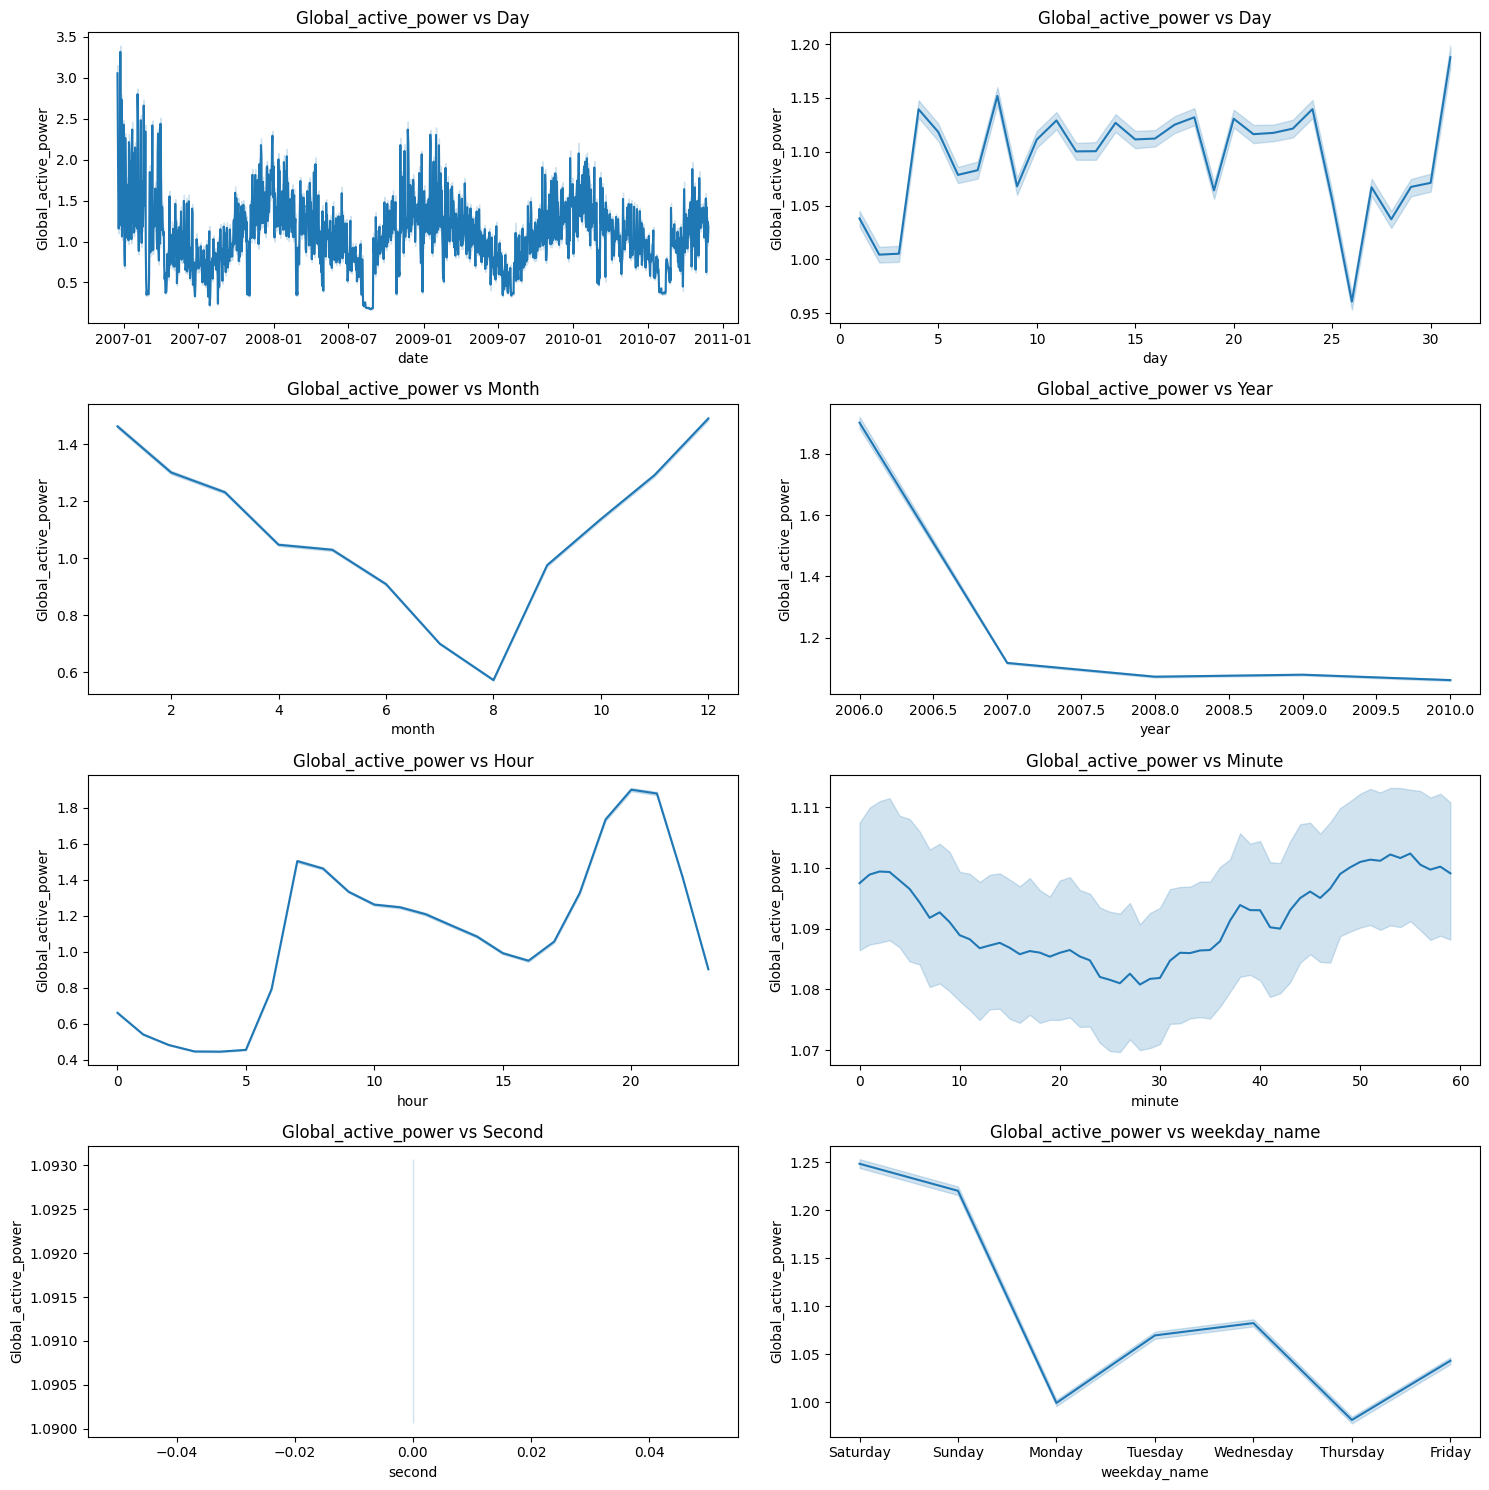

In [7]:
fig, axs = plt.subplots(4, 2, figsize=(15, 15))

sns.lineplot(data=power_forecasting, x='date', y='Global_active_power', ax=axs[0, 0])
axs[0, 0].set_title('Global_active_power vs Day')

sns.lineplot(data=power_forecasting, x='day', y='Global_active_power', ax=axs[0, 1])
axs[0, 1].set_title('Global_active_power vs Day')

sns.lineplot(data=power_forecasting, x='month', y='Global_active_power', ax=axs[1, 0])
axs[1, 0].set_title('Global_active_power vs Month')

sns.lineplot(data=power_forecasting, x='year', y='Global_active_power', ax=axs[1, 1])
axs[1, 1].set_title('Global_active_power vs Year')

sns.lineplot(data=power_forecasting, x='hour', y='Global_active_power', ax=axs[2, 0])
axs[2, 0].set_title('Global_active_power vs Hour')

sns.lineplot(data=power_forecasting, x='minute', y='Global_active_power', ax=axs[2, 1])
axs[2, 1].set_title('Global_active_power vs Minute')

sns.lineplot(data=power_forecasting, x='second', y='Global_active_power', ax=axs[3, 0])
axs[3, 0].set_title('Global_active_power vs Second')

sns.lineplot(data=power_forecasting, x='weekday_name', y='Global_active_power', ax=axs[3, 1])
axs[3, 1].set_title('Global_active_power vs weekday_name')

plt.tight_layout()
plt.show()
